In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings("ignore")



In [2]:
def get_prices(tickers_list, start, end, what_price):
    
    df = pd.DataFrame()
    for ticker in tickers_list:
        tmp = data.DataReader(ticker, 'yahoo', start, end)
        df[ticker] = tmp[what_price]
    return df 

def is_first_friday(date):
    
    if date.weekday() == 4 and date.day <= 7:
        return 1
    else:
        return 0
        
    

In [3]:
tickers = ['SPY', 'IWM', 'TLT','EEM', 'IYR','LQD','TIP','GLD','OIH','FXE'] # 'JNK',, 'GSG'
st = dt.datetime(2005, 12, 31)
ed = dt.datetime(2016, 12, 1)

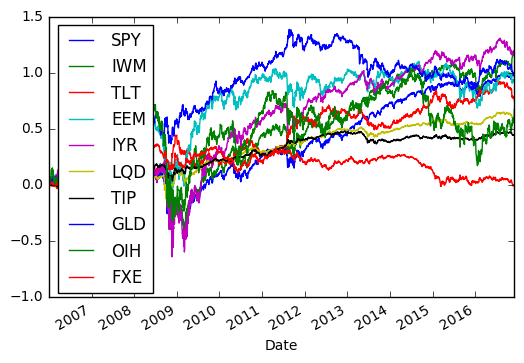

                   SPY        IWM        TLT        EEM        IYR        LQD  \
Date                                                                            
2006-01-03  101.622813  58.659929  62.676043  25.077559  42.020076  67.254051   
2006-01-04  102.104063  58.978870  62.826280  25.304908  42.211364  67.254051   
2006-01-05  102.168224  59.297816  62.751161  25.433655  42.511052  67.309953   
2006-01-06  103.018427  60.004666  62.635071  25.965066  42.880881  67.204360   
2006-01-09  103.283113  60.401191  62.676043  26.219813  43.295344  67.216785   

                  TIP        GLD        OIH         FXE  
Date                                                     
2006-01-03  74.493682  53.119999  36.501920  109.719690  
2006-01-04  74.500913  53.299999  37.157478  110.787853  
2006-01-05  74.284023  52.340000  36.405199  110.550481  
2006-01-06  74.247873  53.720001  37.614227  111.034356  
2006-01-09  74.334630  54.599998  37.538992  110.404411  


In [4]:
prices = get_prices(tickers, st, ed, 'Adj Close')
# Is pct_change good enough? Maybe make it ln(x2/x1)?
returns = prices.pct_change(1).dropna() # dropped first row
returns.cumsum().plot()
plt.show()

In [18]:
horizon = [1, 5, 10, 20, 40, 60, 120, 250]

Scores = pd.DataFrame(index=tickers, columns =[str(x)+' days' for x in horizon])

print(Scores.head())

    1 days 5 days 10 days 20 days 40 days 60 days 120 days 250 days
SPY    NaN    NaN     NaN     NaN     NaN     NaN      NaN      NaN
IWM    NaN    NaN     NaN     NaN     NaN     NaN      NaN      NaN
TLT    NaN    NaN     NaN     NaN     NaN     NaN      NaN      NaN
EEM    NaN    NaN     NaN     NaN     NaN     NaN      NaN      NaN
IYR    NaN    NaN     NaN     NaN     NaN     NaN      NaN      NaN


In [ ]:
in_ = True
for tick in tickers:
        tic()
        for n_fwd in horizon:
            x_base = prices.pct_change(n_fwd).dropna()
            xl1 = x_base.shift(1); xl1 = xl1.add_prefix('Lag1_')  # <- Step 1, add Lag1_, Lag2_, Lag3_

            x_base['WeekDay'] = x_base.index.weekday_name;   x_base = pd.get_dummies(x_base) # <- Step 2, add days and months
            x_base['Month'] = x_base.index.strftime('%b');   x_base = pd.get_dummies(x_base)

            x = x_base.join(xl1).dropna().iloc[:-n_fwd]

            x['First_Friday'] = pd.Series(x.index, index=x.index).apply(is_first_friday)  # <- Step 3, add Non-Farm payrolls dummy

            y = x_base[tick].shift(-n_fwd).iloc[1:-n_fwd]
            y = np.where(y>=0, 1, 0)

            X_train, X_test, y_train, y_test = train_test_split(x, y, 
                    train_size = 0.7, random_state = 0)

            ##### added pipeline #### 
            mlp = MLPClassifier()

            pipe_mlp = Pipeline([('scl', StandardScaler()),
                         ('clf', mlp)])

        #        param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
            param_range = [0.1, 1.0, 10.0, 100.0]

            param_grid = [{'clf__alpha'     : param_range, # regularization strength on L2
                           'clf__activation': ['relu', 'logistic', 'tanh'],
                           'clf__solver'    : ['sgd'],
                           'clf__hidden_layer_sizes' : [(10,10), (10,10,10)]}] 
#                           'clf__hidden_layer_sizes' : [(100,100), (100,100,100)]}] 

            gs = GridSearchCV(estimator = pipe_mlp,
                              param_grid = param_grid,
                              scoring='accuracy',
                              cv = 5,
                              n_jobs = -1)

            gs = gs.fit(X_train, y_train)

            best_mlp = gs.best_estimator_
            best_mlp.fit(X_train, y_train)

            train_score = best_mlp.score(X_train, y_train)
            test_score  = best_mlp.score(X_test, y_test)
            base_score  = (y_test.sum()/len(y_test))

        #        train_score = f1_score(y_train, best_mlp.predict(X_train) ) 
        #        test_score  = f1_score(y_test , best_mlp.predict(X_test)  )

            Scores[str(n_fwd)+' days'][tick] = [train_score, test_score, base_score]

            if in_:
                print('Ticker, Base%, TrainScore, TestScore, next_days_forward ')
                print(tick,',%.3f, %.3f, %.3f, %.f' % (y_test.sum()/len(y_test), train_score, test_score, n_fwd)) 
                in_ = False
            else:
                print(tick,',%.3f, %.3f, %.3f, %.f' % (y_test.sum()/len(y_test), train_score, test_score, n_fwd))        
            
        toc()



Ticker, Base%, TrainScore, TestScore, next_days_forward 
SPY ,0.550, 0.550, 0.550, 1
SPY ,0.585, 0.588, 0.590, 5
SPY ,0.617, 0.636, 0.615, 10
SPY ,0.636, 0.659, 0.636, 20
SPY ,0.647, 0.688, 0.653, 40
SPY ,0.678, 0.762, 0.733, 60
SPY ,0.726, 0.883, 0.884, 120


In [ ]:
# 9:44am how long does 10 yrs take to runs? 4 mins to run one set, 10:00 (run 5 of them) 
# https://research.wealthfront.com/whitepapers/investment-methodology/
    



In [6]:
horizon = [1, 5, 10, 20, 40, 60, 120, 250]

Scores = pd.DataFrame(index=tickers, columns =[str(x)+' days' for x in horizon])

print(Scores.head())

    1 days 5 days 10 days 20 days 40 days 60 days 120 days 250 days
SPY    NaN    NaN     NaN     NaN     NaN     NaN      NaN      NaN
IWM    NaN    NaN     NaN     NaN     NaN     NaN      NaN      NaN
TLT    NaN    NaN     NaN     NaN     NaN     NaN      NaN      NaN
EEM    NaN    NaN     NaN     NaN     NaN     NaN      NaN      NaN
IYR    NaN    NaN     NaN     NaN     NaN     NaN      NaN      NaN


In [17]:
# for RandomForestClassifier

in_ = True
for tick in tickers:
        tic()
        for n_fwd in horizon:
            x_base = prices.pct_change(n_fwd).dropna()
            xl1 = x_base.shift(1); xl1 = xl1.add_prefix('Lag1_')  # <- Step 1, add Lag1_, Lag2_, Lag3_

            x_base['WeekDay'] = x_base.index.weekday_name;   x_base = pd.get_dummies(x_base) # <- Step 2, add days and months
            x_base['Month'] = x_base.index.strftime('%b');   x_base = pd.get_dummies(x_base)

            x = x_base.join(xl1).dropna().iloc[:-n_fwd]

            x['First_Friday'] = pd.Series(x.index, index=x.index).apply(is_first_friday)  # <- Step 3, add Non-Farm payrolls dummy

            y = x_base[tick].shift(-n_fwd).iloc[1:-n_fwd]
            y = np.where(y>=0, 1, 0)

            X_train, X_test, y_train, y_test = train_test_split(x, y, 
                    train_size = 0.7, random_state = 0)

            ##### added pipeline #### 
            rfc = RandomForestClassifier()

            pipe_rfc = Pipeline([('clf', rfc)])

            param_range = [10, 20, 30]

            param_grid = [{'clf__n_estimators' : param_range,
                           'clf__max_depth' : [2,3,4],
                           'clf__criterion': ['entropy','gini']}] #  

            gs = GridSearchCV(estimator = pipe_rfc,
                              param_grid = param_grid,
                              scoring='accuracy',
                              cv = 5,
                              n_jobs = -1)

            gs = gs.fit(X_train, y_train)

            best_rfc = gs.best_estimator_
            best_rfc.fit(X_train, y_train)

            train_score = best_rfc.score(X_train, y_train)
            test_score  = best_rfc.score(X_test, y_test)
            base_score  = (y_test.sum()/len(y_test))

        #        train_score = f1_score(y_train, best_mlp.predict(X_train) ) 
        #        test_score  = f1_score(y_test , best_mlp.predict(X_test)  )

            Scores[str(n_fwd)+' days'][tick] = [train_score, test_score, base_score]

            if in_:
                print('Ticker, Base%, TrainScore, TestScore, next_days_forward ')
                print(tick,',%.3f, %.3f, %.3f, %.f' % (y_test.sum()/len(y_test), train_score, test_score, n_fwd)) 
                in_ = False
            else:
                print(tick,',%.3f, %.3f, %.3f, %.f' % (y_test.sum()/len(y_test), train_score, test_score, n_fwd))        
            
        toc()



Ticker, Base%, TrainScore, TestScore, next_days_forward 
SPY ,0.550, 0.582, 0.540, 1
SPY ,0.585, 0.629, 0.594, 5
SPY ,0.617, 0.666, 0.647, 10
SPY ,0.636, 0.701, 0.665, 20
SPY ,0.647, 0.740, 0.700, 40
SPY ,0.678, 0.745, 0.717, 60
SPY ,0.726, 0.854, 0.845, 120
SPY ,0.769, 0.942, 0.942, 250
Elapsed time: 14.819668 seconds.

IWM ,0.544, 0.592, 0.534, 1
IWM ,0.546, 0.614, 0.558, 5
IWM ,0.584, 0.645, 0.611, 10
IWM ,0.599, 0.672, 0.654, 20
IWM ,0.625, 0.720, 0.697, 40
IWM ,0.641, 0.719, 0.683, 60
IWM ,0.668, 0.871, 0.866, 120
IWM ,0.676, 0.930, 0.924, 250
Elapsed time: 14.385016 seconds.

TLT ,0.546, 0.625, 0.564, 1
TLT ,0.547, 0.661, 0.566, 5
TLT ,0.558, 0.641, 0.582, 10
TLT ,0.557, 0.689, 0.631, 20
TLT ,0.614, 0.734, 0.719, 40
TLT ,0.617, 0.744, 0.703, 60
TLT ,0.673, 0.845, 0.841, 120
TLT ,0.788, 0.973, 0.954, 250
Elapsed time: 14.217296 seconds.

EEM ,0.525, 0.555, 0.513, 1
EEM ,0.518, 0.649, 0.560, 5
EEM ,0.545, 0.591, 0.563, 10
EEM ,0.530, 0.694, 0.647, 20
EEM ,0.547, 0.712, 0.674, 40
EE

In [10]:
pwd()

'/Users/jim/Desktop'

In [ ]:
horizon = [1, 5, 10, 20, 40, 60, 120, 250]

Scores = pd.DataFrame(index=tickers, columns =[str(x)+' days' for x in horizon])

print(Scores.head())

In [ ]:
# for Support Vector Machines

in_ = True
for tick in tickers:
        tic()
        for n_fwd in horizon:
            x_base = prices.pct_change(n_fwd).dropna()
            xl1 = x_base.shift(1); xl1 = xl1.add_prefix('Lag1_')  # <- Step 1, add Lag1_, Lag2_, Lag3_

            x_base['WeekDay'] = x_base.index.weekday_name;   x_base = pd.get_dummies(x_base) # <- Step 2, add days and months
            x_base['Month'] = x_base.index.strftime('%b');   x_base = pd.get_dummies(x_base)

            x = x_base.join(xl1).dropna().iloc[:-n_fwd]

            x['First_Friday'] = pd.Series(x.index, index=x.index).apply(is_first_friday)  # <- Step 3, add Non-Farm payrolls dummy

            y = x_base[tick].shift(-n_fwd).iloc[1:-n_fwd]
            y = np.where(y>=0, 1, 0)

            X_train, X_test, y_train, y_test = train_test_split(x, y, 
                    train_size = 0.7, random_state = 0)

            ##### added pipeline #### 
            svm = SVC()

            pipe_svm = Pipeline([('scl', StandardScaler()),
                                 ('clf', svm)])

#        param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
            param_range = [0.1, 1.0, 10.0, 100.0]

            param_grid = [{'clf__n_estimators' : param_range, 
                           'clf__criterion': ['linear', 'rbf']}]

            gs = GridSearchCV(estimator = pipe_svm,
                              param_grid = param_grid,
                              scoring='accuracy',
                              cv = 5,
                              n_jobs = -1)

            gs = gs.fit(X_train, y_train)

            best_svm = gs.best_estimator_
            best_svm.fit(X_train, y_train)

            train_score = best_svm.score(X_train, y_train)
            test_score  = best_svm.score(X_test, y_test)
            base_score  = (y_test.sum()/len(y_test))

        #        train_score = f1_score(y_train, best_mlp.predict(X_train) ) 
        #        test_score  = f1_score(y_test , best_mlp.predict(X_test)  )

            Scores[str(n_fwd)+' days'][tick] = [train_score, test_score, base_score]

            if in_:
                print('Ticker, Base%, TrainScore, TestScore, next_days_forward ')
                print(tick,',%.3f, %.3f, %.3f, %.f' % (y_test.sum()/len(y_test), train_score, test_score, n_fwd)) 
                in_ = False
            else:
                print(tick,',%.3f, %.3f, %.3f, %.f' % (y_test.sum()/len(y_test), train_score, test_score, n_fwd))                    
        toc()


In [8]:
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

In [ ]:
tic()


toc()